# Scoring Elaticsearch Results
## LMI Capstone Team
## Summer Chambers | Steve Morris | Kaleb Shikur

### Setup

In [1]:
import pandas as pd
import numpy as np
import json
import math
from statistics import mode
from sklearn.metrics import ndcg_score, f1_score, average_precision_score
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
metadata_url = "https://mikeanders.org/data/CMS/CMS-2018-0101-0001/CMS-1701-P%20Comment%20MetaData.csv"
data = pd.read_csv(metadata_url, usecols=range(0,36))[:469] #ignore last few columns and blank rows at end of csv 
data = data.rename(columns=lambda x: x.strip()) #strip whitespace from columns

In [3]:
data10 = data.fillna(0) #fill NaN with 0

section_cols = data10.columns[3:] 
data10[section_cols] = data10[section_cols].replace(["Y"], 1) #replace Y with 1 in approriate columns
data11 = data10.copy()
section_cols1  = data11.columns[3:] 
data11[section_cols1] = np.where((data11[section_cols1]  != 1), 0, data11[section_cols1])

# Combining columns for index matching: (A6b, A6b.1, = A6b),  (C3b, C3b.1'= C3b) ('A7', 'A7.1', 'A7.2', = A7b, a7c),  (F = F2, F3)

data11['A6b'] = (data11['A6b'] + data11['A6b.1'])
data11['A6b'] = data11['A6b'].replace(2,1)
data11['C3b'] = (data11['C3b'] + data11['C3b.1'])
data11['C3b'] = data11['C3b'].replace(2,1)
data11['A7'] = (data11['A7'] + data11['A7.1'] + data11['A7.2'])
data11['A7'] = data11['A7'].replace(2,1)
data11['A7'] = data11['A7'].replace(3,1)

data11 = data11.drop(['A6b.1', 'C3b.1', 'A7.1', 'A7.2'], axis=1)
data11 = data11[0:468]
data11.Name = [name.split('DRAFT-')[1].split('-')[0] for name in data11.Name]
data11 = data11.rename(columns=lambda x: x.lower())
section_cols1 = data11.columns[3:]

In [4]:
data11

,name,organization name / submitter name,submitter state,a2,a3,a4b,a4c,a5b,a5c,a5d,...,d3c,d3d,d4,e2,e3,e4,e5,e6,e7,f
0,0002,Erick Meleher,NC,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0003,Mayank Shah,IL,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2,0004,Mayank Shah,IL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0005,Morey Menacker,NJ,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0006,Todd Rapoza,MA,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,0465,Morehouse Choice Accountable Care Organization...,GA,1,1,0,0,1,0,1,...,1,0,0,0,0,0,0,1,0,0
464,0466,Liberty ACO,TX,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
465,0467,Washington State Hospital Association,WA,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
466,0468,Think Whole Person Healthcare,NE,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
truth_dict = {} # initiate dict
for i, name in enumerate(data11.name): # iterate through Comment Names
    dict1 = {col:data11[col].iloc[i] for col in section_cols1} # locate this row's values for each column
    list1 = [key for key,value in dict1.items() if value==1] # create list of matching sections for this row
    truth_dict[name] = list1 # add Comment Name and list of matching sections to dict

In [6]:
with open("unique_comments2018.json") as f:
    unique_comments2018 = json.load(f)

In [7]:
unique_data = data11.loc[data11['name'].isin(unique_comments2018.keys())]

In [8]:
unique_truth_dict = {} # initiate dict
for i, name in enumerate(unique_data.name): # iterate through Comment Names
    dict1 = {col:unique_data[col].iloc[i] for col in section_cols1} # locate this row's values for each column
    list1 = [key for key,value in dict1.items() if value==1] # create list of matching sections for this row
    unique_truth_dict[name] = list1 # add Comment Name and list of matching sections to dict

In [9]:
dump = json.dumps(unique_truth_dict)
f = open('unique_truth_dict.json','w')
f.write(dump)
f.close()

In [11]:
#define true rule section names
truth_keys = list(section_cols1)
truth_keys = [key1.lower() for key1 in truth_keys]

### Which comments were scored poorly?

In [ ]:
with open("comments2018.json") as f:
    comments2018 = json.load(f)

In [ ]:
poorf1 = headers_eval.query("F1 < 0.5").F1
poorf1

In [ ]:
poorndcg = headers_eval.query("NDCG < 0.3 & NDCG > 0").NDCG
poorndcg

In [ ]:
poorf1_comments = {key:comment for key, comment in comments2018.items() if key in poorf1}
{key:len(comment) for key, comment in poorf1_comments.items()}

In [ ]:
poorf1_comments_truth = {key:matches for key, matches in truth_dict.items() if key in poorf1}
poorf1_comments_truth

In [ ]:
poorndcg_comments = {key:comment for key, comment in comments2018.items() if key in poorndcg}
{key:len(comment) for key, comment in poorndcg_comments.items()}

In [ ]:
poorndcg_comments_truth = {key:matches for key, matches in truth_dict.items() if key in poorndcg}
poorndcg_comments_truth

## Headers Unique Index Testing

In [12]:
with open('unique_header_results.json') as f:
    unique_header_results = json.load(f)

In [13]:
#tranlate ES keys to true rule section names, MAINTAINING ORDER
for key, value in unique_header_results.items():
    value_list = []
    for val_idx, score in value.items():
        for true_key in truth_keys:
            if true_key in val_idx and true_key not in value_list: 
                value_list.append(true_key)
        unique_header_results[key]={true_key: score for (val_idx, score), true_key in zip(value.items(),value_list)}     

### Normalize scores (divide by mean)

In [16]:
normalized_results = {}
for comment_idx, result in unique_header_results.items():
    score_mean = np.mean(list(result.values()))
    score_dict = {}
    for rule_idx, score in result.items():
        score_dict[rule_idx] = score/score_mean
    normalized_results[comment_idx] = score_dict

In [18]:
normalized_lists = {comment_idx:list(score_dict.items()) for comment_idx, score_dict in normalized_results.items()}

### Merge results for same comment chunks

In [49]:
merged_results = {}
for key in unique_truth_dict.keys():
    merged_list = []
    for comment_idx, result_list in normalized_lists.items():
        if key in comment_idx:
            merged_list.extend(result_list)
    merged_results[key] = merged_list
merged_results = {comment_idx:sorted(result, key=lambda x:x[1], reverse=True) for comment_idx, result in merged_results.items()}

In [50]:
for comment_idx, tup_list in merged_results.items():
    score_dict = {}
    for tup in tup_list:
        if tup[0] in score_dict.keys():
            score_dict[tup[0]] += tup[1]
        else:
            score_dict[tup[0]] = tup[1]
    merged_results[comment_idx] = score_dict

In [51]:
merged_results = {comment_idx:dict(sorted(result.items(), key = lambda x:x[1], reverse=True))\
                  for comment_idx, result in merged_results.items()}

### Sklearn

In [55]:
#create truth dict with values equal to sparse array length=29, binary
unique_truth_dict_all = unique_truth_dict.copy()
for key, value in unique_truth_dict.items():
    new_value_list = np.zeros(len(truth_keys))
    for val in value:
        for i in range(len(truth_keys)):
            if val == truth_keys[i]:
                new_value_list[i] = 1
    unique_truth_dict_all[key] = new_value_list

In [57]:
#create header results dict with values equal to sparse array length=29, (discounted and binary versions)
unique_header_results_all = unique_header_results.copy()
unique_binary_header_results_all = unique_header_results.copy()
for key, value in unique_header_results.items():
    new_value_list_discounted = np.zeros(len(truth_keys))
    new_value_list_binary = np.zeros(len(truth_keys))
    counter = 1
    for rule_section in value.keys():
        for i in range(len(truth_keys)):
            if rule_section == truth_keys[i]:
                counter += 1
                new_value_list_discounted[i] = 1/math.log(counter, 2)
                new_value_list_binary[i] = 1
    unique_header_results_all[key] = new_value_list_discounted
    unique_binary_header_results_all[key] = new_value_list_binary

In [75]:
unique_headers_ndcg = {}
unique_headers_ap = {}
unique_headers_f1 = {}
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), unique_header_results_all.items()):
    unique_headers_ndcg[true_key] = ndcg_score([true_value], [es_value])
    unique_headers_ap[true_key] = average_precision_score(true_value, es_value, pos_label=0)
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), unique_binary_header_results_all.items()):
    unique_headers_f1[true_key] = f1_score(true_value, es_value, zero_division=0, pos_label=0)

In [76]:
unique_headers_eval = pd.DataFrame(data=[unique_headers_ndcg, unique_headers_ap, unique_headers_f1]).T
unique_headers_eval = unique_headers_eval.rename({0:"NDCG", 1:"AP", 2:"F1"}, axis=1)

In [77]:
unique_headers_eval.describe()

,NDCG,AP,F1
count,94.000000,94.000000,94.000000
mean,0.504945,0.811299,0.737718
std,0.263038,0.206214,0.105868
min,0.000000,0.068966,0.190476
25%,0.292056,0.751632,0.714286
50%,0.500000,0.891180,0.765957
75%,0.715304,0.958766,0.791667
max,0.993542,1.000000,0.888889


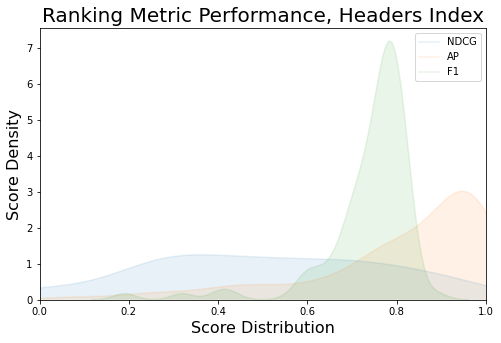

In [79]:
plt.figure(figsize = (8,5))
sns.kdeplot(unique_headers_eval.NDCG, alpha=.1, shade=True, label='NDCG')
sns.kdeplot(unique_headers_eval.AP, alpha=.1, shade=True,label='AP')
sns.kdeplot(unique_headers_eval.F1,  alpha=.1, shade=True,label='F1')
plt.legend()
plt.title('Ranking Metric Performance, Headers Index', fontsize=20)
plt.xlabel('Score Distribution', fontsize=16)
plt.ylabel('Score Density', fontsize=16)
plt.xlim(0,1);

## Hybrid Index Testing

In [ ]:
with open('hybrid_results.json') as f1:
    hybrid_results_json = json.load(f1)

In [ ]:
#tranlate ES keys to true rule section names, MAINTAINING ORDER
for key, value in hybrid_results_json.items():
    value_list = []
    for val_idx in value:
        for true_key in truth_keys:
            if true_key in val_idx[0:4] and true_key not in value_list:
                    value_list.append(true_key)
        hybrid_results_json[key]=value_list            

In [ ]:
# match_dict shows all true positives, without penalty to false categorization
match_dict= {}
for (key1, value1), (key2, value2) in zip(truth_dict.items(), hybrid_results_json.items()):
    match_count = 0
    for val_idx in value1:
            if val_idx in value2:
                match_count += 1
            match_dict[key1]=match_count/len(value1)

In [ ]:
# unpenalized accuracy of true positives
meanvals = np.mean(list(match_dict.values()))
meanvals

In [ ]:
# match_dict1 shows all true positives, with penalty to false categorization
match_dict1= {}
for (key1, value1), (key2,value2) in zip(truth_dict.items(), hybrid_results_json.items()):
    match_count = 0
    for val_idx in value2:
        if val_idx in value1:
            match_count += 1
        match_dict1[key1]=match_count/len(value2)

In [ ]:
# penalized accuracy of true positives
meanvals1 = np.mean(list(match_dict1.values()))
meanvals1

In [ ]:
np.mean([meanvals,meanvals1])

### SKlearn NDCG Hybrid

In [ ]:
#create header results dict with values equal to sparse array length=29, binary
binary_hybrid_results_all = hybrid_results_json.copy()
for key, value in hybrid_results_json.items():
    new_value_list = np.zeros(len(truth_keys))
    for val in value:
        for i in range(len(truth_keys)):
            if val == truth_keys[i]:
                new_value_list[i] = 1
    binary_hybrid_results_all[key] = new_value_list

In [ ]:
#create header results dict with values equal to sparse array length=29, binary (discounted)
hybrid_results_all = hybrid_results_json.copy()
for key, value in hybrid_results_json.items():
    new_value_list = np.zeros(len(truth_keys))
    counter = 1
    for val in value:
        for i in range(len(truth_keys)):
            if val == truth_keys[i]:
                counter += 1
                new_value_list[i] = 1/math.log(counter, 2)
    hybrid_results_all[key] = new_value_list

In [ ]:
hybrid_ndcg = {}
hybrid_ap = {}
hybrid_f1 = {}
for (true_key, true_value), (es_key, es_value) in zip(truth_dict_all.items(), hybrid_results_all.items()):
    hybrid_ndcg[true_key] = ndcg_score([true_value], [es_value])
    hybrid_ap[true_key] = average_precision_score(true_value, es_value, pos_label=0)
for (true_key, true_value), (es_key, es_value) in zip(truth_dict_all.items(), binary_hybrid_results_all.items()):
    hybrid_f1[true_key] = f1_score(true_value, es_value, zero_division=0, pos_label=0)

In [ ]:
hybrid_eval = pd.DataFrame(data=[hybrid_ndcg, hybrid_ap, hybrid_f1]).T

In [ ]:
hybrid_eval = hybrid_eval.rename({0:"NDCG", 1:"AP", 2:"F1"}, axis=1)

In [ ]:
Hybrid_mean_scores = hybrid_eval.mean()
Hybrid_mean_scores

In [ ]:
plt.figure(figsize = (14,10))
sns.kdeplot(hybrid_eval.NDCG, alpha=.1, shade=True, label='NDCG')
sns.kdeplot(hybrid_eval.AP, alpha=.1, shade=True,label='AP')
sns.kdeplot(hybrid_eval.F1,  alpha=.1, shade=True,label='F1')
plt.legend()
plt.title('Ranking Metric Performance, Hybrid Index', fontsize=20)
plt.xlabel('Score Distribution', fontsize=16)
plt.ylabel('Score Density', fontsize=16)
plt.xlim(0,1);

### Which comments were scored poorly?

In [ ]:
poorf1 = hybrid_eval.query("F1 < 0.5").F1
poorf1

In [ ]:
poorndcg = hybrid_eval.query("NDCG < 0.3 & NDCG > 0").NDCG
poorndcg

In [ ]:
poorf1_comments = {key:comment for key, comment in comments2018.items() if key in poorf1}
{key:len(comment) for key, comment in poorf1_comments.items()}

In [ ]:
poorf1_comments_truth = {key:matches for key, matches in truth_dict.items() if key in poorf1}
poorf1_comments_truth

In [ ]:
poorndcg_comments = {key:comment for key, comment in comments2018.items() if key in poorndcg}
{key:len(comment) for key, comment in poorndcg_comments.items()}

In [ ]:
poorndcg_comments_truth = {key:matches for key, matches in truth_dict.items() if key in poorndcg}
poorndcg_comments_truth